## Generating Dataset
Let's create the toy dataset. We'll have a 1 16x16 image with a 4x4 square placed somewhere inside.

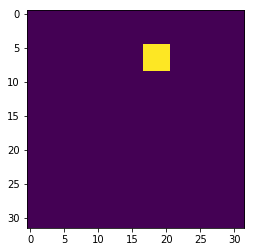

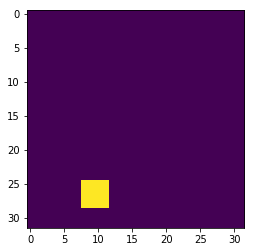

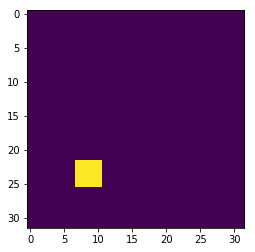

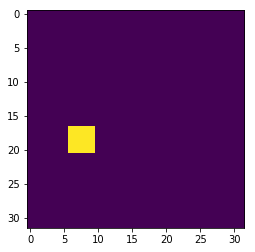

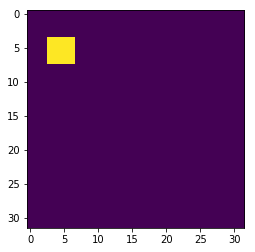

In [51]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(5):

    img = np.zeros((1,3,32,32), dtype=np.float32)
    pos_r = np.random.randint(0, img.shape[2]-4-1)
    pos_c = np.random.randint(0, img.shape[3]-4-1)
    img[0,:,pos_r:pos_r+4,pos_c:pos_c+4]=1
    plt.imshow(img[0,0,:,:])
    plt.show()

## Generating Feature maps
Now that we have the image, we'll go over it one by one and generate feature maps of size 4x4.

In [52]:
from chainer import Chain
import chainer
import chainer.functions as F
import chainer.links as L

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__(
            l1=L.Convolution2D(None,32,ksize=(3,3),stride=1,pad=1),
            l2=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l3=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1)
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.max_pooling_2d(h1, 2)
        h3 = F.relu(self.l2(h2))
        h4 = F.max_pooling_2d(h3, 2)
        h5 = F.relu(self.l3(h4))
        h6 = F.max_pooling_2d(h5, 2)
        return self.l3(F.sigmoid(h6))

## Linear Convolution to generate shifts

In [53]:
class BoxNet(Chain):
    def __init__(self):
        super(BoxNet, self).__init__(
            l1=L.Convolution2D(None,6,ksize=(3,3),stride=1,pad=1)
        )
        
    def __call__(self, x):
        h1 = self.l1(x)
        return h1
    
convnet = ConvNet()
boxnet = BoxNet()
fm = convnet(img)
shifts = boxnet(fm)
print(shifts)

variable([[[[-0.09093749  0.06988604  0.17117518  0.26950037]
            [ 0.04216633 -0.10692932  0.11639939  0.19835556]
            [-0.0249717   0.02130342  0.25065893  0.37125021]
            [ 0.05736393 -0.04375185  0.08540154  0.07669716]]

           [[ 0.17818767  0.4652521   0.54704636  0.38989955]
            [ 0.44880664  0.82288855  0.89914662  0.61651731]
            [ 0.26404074  0.42489031  0.46692136  0.27147734]
            [ 0.15851171  0.21476147  0.11180552  0.01780128]]

           [[ 0.38147834  0.27166617  0.40060735  0.04114417]
            [-0.02091634 -0.00395895  0.37049526  0.17888544]
            [-0.06631128  0.00697725  0.50619948  0.22593097]
            [-0.5283789  -0.34211403  0.08596464  0.17075142]]

           [[ 0.07079417  0.25496429  0.20514363  0.1940642 ]
            [ 0.12411312  0.236926    0.39629298  0.2459525 ]
            [ 0.25473559  0.25408283  0.33104503  0.08043738]
            [ 0.23116225 -0.01340183  0.02512261 -0.29653481]]



## Draw generated default boxes on top of the original image

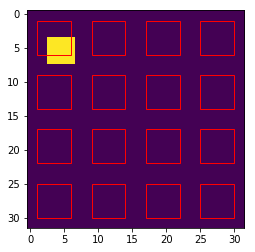

dtype('float32')

In [54]:
from matplotlib import patches

def defaultgen(I, F, width, height):
    """
    Generates an array of default boxes: Chainer TESTED
    
    Args:
        I: Input image tensor (N,channels,rows,cols)
        F: Feature map tensor to generate default boxes for
        width: Width of the box
        height: Height of the box
        
    Returns:
        db: Default boxes tensor, flattened
    """
    scale = I.shape[2] / F.shape[2]
    offset = np.ones((2,F.shape[2],F.shape[3]), dtype=np.float32)
    iterator = np.flip(np.indices((F.shape[2],F.shape[3])), axis=0).astype(np.float32)
    
    xys = offset * ((scale-1)/2) + iterator * scale
    xys = np.moveaxis(xys,0,2)
    ws = np.full((F.shape[2],F.shape[3],1), width, dtype=np.float32)
    hs = np.full((F.shape[2],F.shape[3],1), height,dtype=np.float32)
    class_scores = np.zeros((F.shape[2],F.shape[3],2), dtype=np.float32)
    
    db = np.dstack([xys, ws, hs, class_scores])
    
    return chainer.Variable(db.reshape((db.shape[0] * db.shape[1], 6)))

def center_to_coords(box):
    """ 
    Converts bounding box from (cx, cy, w, h) format to (x1, y1, x2, y2) format
    
    Args:
        box: 6d numpy array
        
    Returns:
        box_transformed: Box in the second format
    
    """
    box_transformed = np.array([box[0]-box[2]/2.0, box[1]+box[3]/2.0, box[0]+box[2]/2.0, box[1]-box[3]/2.0, box[4], box[5]])
    return box_transformed


def draw_boxes(img, boxes):
    plt.figure()
    ax = plt.axes()

    for box in boxes:
        box = center_to_coords(box.data)
        ax.imshow(img[0,0,:,:])
        p = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red')
        ax.add_patch(p)

    plt.show()

def_boxes = defaultgen(img, fm, 5,5)
def_boxes[0][2:4]
draw_boxes(img, def_boxes)
def_boxes.dtype


## Draw predictions on top of the original image
Now with the shift tensor we have obtained from running convnet and boxnet together, let's offset the default boxes.

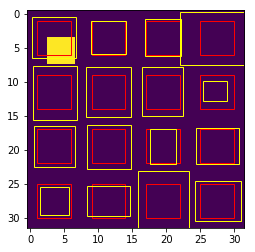

In [55]:
def get_pred_boxes(shift_vals, default_boxes ): 
    """
    Get predicted boxes by combining shift values to default boxes
    Input: 

    shift_values : Shifts generated by the network  NDarray (None, Num of Default boxes, 4+num of classes)
    Default boxes  : Default boxes generated by the network NDarray (None, Num of Default boxes, 4+num of classes)

    Output: 

    Predicted boxes  : Predicted boxes, same shape as default boxes  NDarray (None, Num of Default boxes, 4+num of classes)

    """
    shift_vals= shift_vals.reshape(4*4,6)

    shifts = shift_vals 
    def_boxes= default_boxes
    
    
    cx_pred = (shifts[:,0]*shifts[:,2])+def_boxes[:,0]
    cy_pred = (shifts[:,1]*shifts[:,2])+def_boxes[:,1]
    
    H_pred = F.exp(shifts[:,2])*def_boxes[:,2]
    W_pred = F.exp(shifts[:,3])*def_boxes[:,3]
    
    class1 = shifts[:,4]
    class2 = shifts[:,5]
    
    
    pred_boxes = F.vstack((cx_pred,cy_pred,W_pred,H_pred, class1, class2))
    pred_boxes = F.transpose(pred_boxes)
    
    return  pred_boxes 


def draw_pred_boxes(prediction_boxes, default_boxes): 
    """Draw predicted boxes on the original image """
    
    pred_boxes= prediction_boxes
    def_boxes =default_boxes.data
    pred_boxes = get_pred_boxes(shifts, def_boxes)
     
    boxes = pred_boxes.data
    
    plt.figure()
    ax = plt.axes()

    for i in range(def_boxes.shape[0]):
        box = def_boxes[i]
        box2 =boxes[i]            
        box = center_to_coords(box)
        box2 = center_to_coords(box2)            
        ax.imshow(img[0,0,:,:])

        default_boxes = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color = 'red')
        pred_boxes = patches.Rectangle((box2[0], box2[1]), box2[2]-box2[0], box2[3]-box2[1], fill=False, color = 'yellow')

        ax.add_patch(default_boxes)
        ax.add_patch(pred_boxes)


    plt.show()
#     plt.savefig('shifts')





pred_boxes = get_pred_boxes(shifts, def_boxes)
draw_pred_boxes(pred_boxes, def_boxes)

## Do matching

In [6]:
# Let's define some useful functions first.
# Work with chainer variables for instahook.
#from chainer.functions import max, min, hstack

def iou_cpu(boxA, boxB):
    """
    Calculates intersection over union score of two rectangles, none of them rotated.: TESTED
    
    Args:
        boxA: Box1
        boxB: Box2
        
    Returns:
        iou (scalar): IOU score of the two boxes
    """
        # determine the (x, y)-coordinates of the intersection rectangle
        # Maybe we can accelerate this by writing this as a cython extension
        
    boxA = center_to_coords(boxA)
    boxB = center_to_coords(boxB)
    
    xA = max(boxA[0], boxB[0])
    yA = min(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = max(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxa_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxb_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    #print(interArea, boxa_area, boxb_area)
    iou = interArea / (boxa_area + boxb_area - interArea)

    # return the intersection over union value
    return iou

def find_match_indices_cpu(pred_boxes, gt): 
    """
    Find matches between ground truth boxes and boxes predicted by network.
    
    Args:
        gt (): Tensor of ground truth boxes
        pred_boxes (): Tensor of predicted boxes
        
    Returns:
        pos_inds: Indices of the connectivity matrix where there is a positive match
        neg_inds: Indices of the connectivity matrix where there is a negative match
    """
    
    pos_iou_score =  np.zeros((gt.shape[0], pred_boxes.shape[0]))
    neg_iou_score = np.ones((gt.shape[0], pred_boxes.shape[0]))
    
    for i in range(gt.shape[0]): 
        for j in range(pred_boxes.shape[0]): 
            iou_score  = iou_cpu(gt[i].data, pred_boxes[j].data)
            
            if iou_score > 0.5:  
                pos_iou_score[i,j] = iou_score
            else :
                neg_iou_score[i,j] = iou_score
    
    pos_inds  = np.argwhere(pos_iou_score>0.5)
    neg_inds = np.argwhere(neg_iou_score<=0.5)
    
    return  pos_inds, neg_inds

Ok let's try some examples now and see if it works. Copy pasting some unit tests from before.

In [7]:
# In the default network, these variables will be parameterized
gt = chainer.Variable(np.array([[0.5,0.5,3,3,0,0]], dtype=np.float32))
pred_boxes = chainer.Variable(np.array([[0,0,4,2,0,0], [2.5,2.5,3,3,0,0], [12.5,2.5,3,3,0,0]], dtype=np.float32))
def_boxes = chainer.Variable(np.array([[0,0,4,2,0,0], [2.5,2.5,3,3,0,0], [12.5,2.5,3,3,0,0]], dtype=np.float32))

iou_cpu(gt[0].data, pred_boxes[1].data)
pos_inds, neg_inds = find_match_indices_cpu(pred_boxes, gt)

#pos_inds
np.testing.assert_array_equal(pos_inds[0], [0, 0], 'Posititve matching not working')
np.testing.assert_array_equal(neg_inds[0], [0, 1], 'Negative matching not working')
np.testing.assert_array_equal(neg_inds[1], [0, 2], 'Positive matching not working')

#box1 = gt[0]
#box2 = pred_boxes[0]

Awesome. The tests work and we are able to get the pos_inds just fine.

## Compute regression loss from indices (brute force for loop cpu)
* Run for loop over all the positive indices.
* Calculate relative shift vector for ground truth.
* Regress for relative shift vector with prediction shift vector.

In [8]:
regression_loss = chainer.Variable(np.array([0]))
regression_loss += 1

In [9]:
from chainer.functions import log, hstack, huber_loss

def normalize_shift(box, def_box):
    """
    Scales down absolute shifts, % for centers, log for height and width.
    
    Args:
        box: 6x1 bounding box coordinates
        def_box: 6x1 reference box coordinates
        
    Returns:
        normalized_shift_vector: 4x1 normalized shift vector. Note that we discard the last 2 channels.
    """
    tx = (box[0] - def_box[0])/def_box[2]
    ty = (box[1] - def_box[1])/def_box[3]
    tw = log(box[2]/def_box[2])
    th = log(box[3]/def_box[3])
    
    return hstack([tx, ty, tw, th])
    

def regression_loss(pred_box, gt_box, def_box):
    """
    Calculates regression loss between two boxes w.r.t a reference default box.
    
    Args:
        pred_box: 6x1 bounding box predicted by the network
        gt_box: 6x1 bounding box overlapping with pred_box
        def_box: 6x1 bounding box with same index as pred_box
        
    Returns:
        reg_loss: Scalar of huber loss between two vectors
    """
    pred_shift = normalize_shift(pred_box, def_box).reshape((1, 4))
    gt_shift = normalize_shift(gt_box, def_box).reshape((1, 4))
    
    return huber_loss(pred_shift, gt_shift, delta=0.5)

So let's try it for the boxes above and see if it actually works.

In [10]:
regression_loss(pred_boxes[0], gt[0], def_boxes[0])

variable([ 0.16264397])

Awesome. No bugs. Still have to check it for logical consistency though. Moving on to implement classification loss

## Compute classification loss from indices (brute force for loop cpu). All DONE!

In [11]:
from chainer.functions import softmax, log, matmul

def soft_max(x): 
    
    x = x.reshape([1,2])
    soft_score  = F.softmax(x)
    soft_score =soft_score.reshape([2])
    return soft_score

def classification_loss(pred_box, gt_box, switch):
    """
    Calculates classification loss between two predicted and true box.
    
    Args:
        pred_box: 6x1 box, last two are classification scores
        gt_box: 6x1 box, last two are classification scores
        switch: Positive or negative indicator
        
    Returns:
        loss: Scalar positive or negative cross entropy loss. Only one is active at a time.
    """
    pred_prob = soft_max(pred_box[4:6])
    gt_prob =soft_max(gt_box[4:6])
    
    pos_loss = -matmul(gt_prob, log(pred_prob).transpose())
    neg_loss = -matmul(gt_prob, log(1.0 - pred_prob).transpose())
    
    loss = switch * pos_loss + (1 - switch) * neg_loss
    return loss
    
classification_loss(pred_boxes[0], gt[0], 1.0)    



variable(0.6931471824645996)

In [12]:
pred_box= pred_boxes[0]
gt_box = gt[0]

c1_scores = pred_box[4:6]
c1_scores = c1_scores.reshape([1,2])

c2_scores = gt_box[4:6]
c2_scores = c2_scores.reshape([1,2])

c1_prob = F.softmax(c1_scores)
c2_prob =F.softmax(c2_scores)
print(c1_prob, c2_prob)



variable([[ 0.5  0.5]]) variable([[ 0.5  0.5]])


In [13]:
c1_prob-1

variable([[-0.5, -0.5]])

In [14]:
from chainer.functions import matmul
matmul(c1_prob, c2_prob.transpose())

variable([[ 0.5]])